<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles de convai de conversaciones en ingleś. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import re

import numpy as np
import pandas as pd

import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

In [70]:
# Descargar la carpeta de set
import os
import gdown
url = 'https://drive.google.com/file/d/124U9K39RA-DwAgOrRX_411IgYxXMaV8I/view?usp=sharing'
output = 'data_intermediate.json'
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=124U9K39RA-DwAgOrRX_411IgYxXMaV8I
To: /content/data_intermediate.json
100%|██████████| 739k/739k [00:00<00:00, 47.2MB/s]


'data_intermediate.json'

In [71]:
# dataset_file
import json

text_file = "data_intermediate.json"
with open(text_file) as f:
    data = json.load(f)

In [72]:
data[0]

{'bot_profile': ['i try various coffees as a hobby.',
  'i enjoy poetry.',
  'i am a huge star wars fan.',
  'i played football for a division a college.'],
 'dialog': [{'evaluation_score': None,
   'id': 0,
   'sender': 'participant1',
   'sender_class': 'Human',
   'text': 'Are u there?'}],
 'end_time': '2018-07-09 04:29:15',
 'eval_score': 1,
 'participant1_id': {'class': 'User', 'user_id': 'User 00431'},
 'participant2_id': {'class': 'Bot', 'user_id': 'Bot 005'},
 'profile_match': 1,
 'start_time': '2018-07-09 04:29:15',
 'user_profile': ['my favourite music is country music.',
  'i drive a nissan pathfinder.',
  'i met taylor swift.',
  "i've short brown hair."]}

In [73]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [74]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 1590


In [75]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ',
 'i am doing well how are you  <eos>',
 '<sos> i am doing well how are you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [76]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [77]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 811
Sentencia de entrada más larga: 9


In [78]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 815
Sentencia de salida más larga: 10


In [16]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
#max_input_len = 16
#max_out_len = 18

In [79]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 1590
encoder_input_sequences shape: (1590, 9)
decoder_input_sequences shape: (1590, 10)


In [80]:
from keras.utils.np_utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(1590, 10, 816)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [19]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:03<00:00, 168MB/s]


In [89]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [90]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [91]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 21


In [92]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(811, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [93]:
max_input_len

9

In [94]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 9, 50)        40550       ['input_11[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, 10, 128)      104448      ['input_12[0][0]']               
                                                                                            

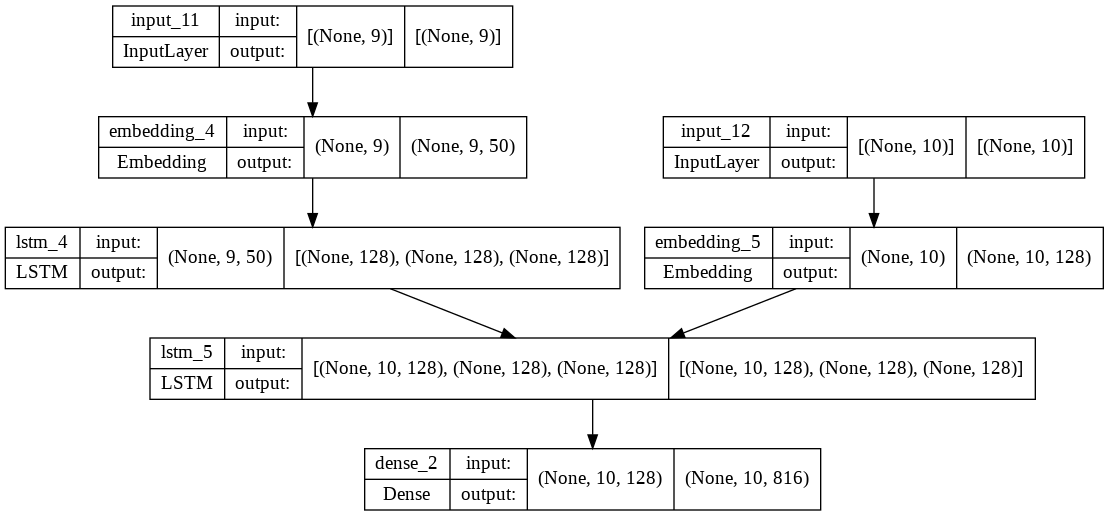

In [95]:
# Modelo completo (encoder+decoder) para poder entrenar
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

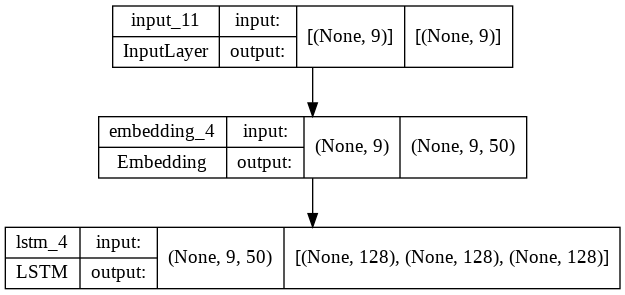

In [96]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

from keras.utils.vis_utils import plot_model
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

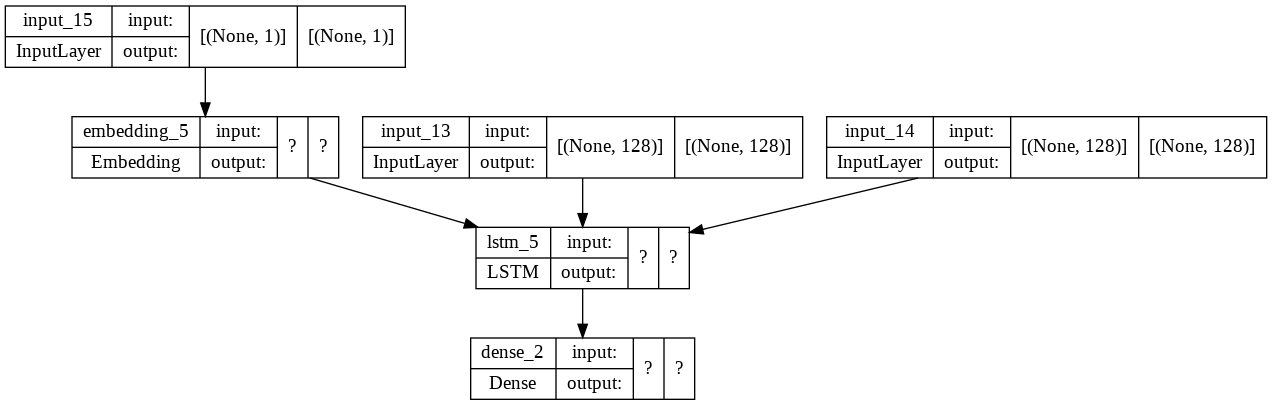

In [97]:
# Modelo solo decoder (para realizar inferencia)
from keras.utils.vis_utils import plot_model

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# EN cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shup de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [98]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50, 
    validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 6s 43ms/step - loss: 4.1826 - accuracy: 0.4752 - val_loss: 2.7860 - val_accuracy: 0.5101
Epoch 2/50
40/40 [==============================] - 1s 17ms/step - loss: 2.5256 - accuracy: 0.5231 - val_loss: 2.5654 - val_accuracy: 0.5330
Epoch 3/50
40/40 [==============================] - 1s 17ms/step - loss: 2.2732 - accuracy: 0.5714 - val_loss: 2.3762 - val_accuracy: 0.5984
Epoch 4/50
40/40 [==============================] - 1s 17ms/step - loss: 2.1261 - accuracy: 0.6160 - val_loss: 2.3208 - val_accuracy: 0.6148
Epoch 5/50
40/40 [==============================] - 1s 19ms/step - loss: 2.0538 - accuracy: 0.6175 - val_loss: 2.2783 - val_accuracy: 0.6164
Epoch 6/50
40/40 [==============================] - 1s 17ms/step - loss: 1.9905 - accuracy: 0.6211 - val_loss: 2.2452 - val_accuracy: 0.6214
Epoch 7/50
40/40 [==============================] - 1s 17ms/step - loss: 1.9282 - accuracy: 0.6365 - val_loss: 2.2171 - val_accuracy: 0.6311
Epoch 8/50
40

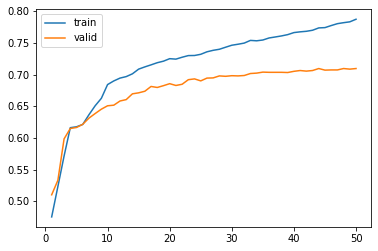

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [100]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [101]:
def responde_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [112]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
respuesta = responde_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', respuesta)

-
Input: i love hiking and skating
Response: i like to listen to music


In [113]:
input_test = "Coffee"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
print('Input:', input_test)
states_value = encoder_model.predict(encoder_sequence_test)
respuesta = responde_sentence(encoder_sequence_test)
print('Response:', respuesta)

Input: Coffee
Representacion en vector de tokens de ids []
Padding del vector: [[0 0 0 0 0 0 0 0 0]]
Input: Coffee
Response: i love to listen to music


**6. Conclusiones**

El modelo realiza algo de overfitting como en el anterior dataset.

**Tras entrenarlo con 50 épocas, obtenemos resultados como:**

Input: no what about you
Response: i am a little depressed

Input: Hello.
Response: i like to listen to music

Input: Are you ok?
Response: i am a little depressed

Input: i love hiking and skating
Response: i like to listen to music

**Las respuestas parecen acotadas, pero conservan una cierta coherencia**


